In [460]:
import pandas as pd
import numpy as np
from numpy import inf
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [461]:
import os
os.chdir('/Users/KevinShao/Desktop/adsi_group2leftfeet')

In [462]:
test = pd.read_csv("data/raw/test.csv")
train = pd.read_csv("data/raw/train.csv")
target = train.pop("TARGET_5Yrs")

In [463]:
#changing negative values to 0 
train[train < 0] = 0
test[test < 0] = 0

In [464]:
X_all = np.concatenate((train, test), axis=0)

In [412]:
#Normalizing the data as some might have % and other might have higher value such as GP and MIN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)

In [465]:
from sklearn.preprocessing import QuantileTransformer
sc = QuantileTransformer()
X_all = sc.fit_transform(X_all)
from sklearn.kernel_approximation import AdditiveChi2Sampler
sc = AdditiveChi2Sampler()
X_all = sc.fit_transform(X_all)

In [472]:
df_train=X_all[:8000]

In [473]:
df_test=X_all[:-3799]

In [474]:
df_train = train.iloc[:, 1:].values
df_test = test.iloc[:, 1:].values

In [475]:
print(df_train.shape)

(8000, 19)


In [416]:
#Upsmapling
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=8)
training_set, target = sm.fit_sample(df_train, target)
print(target.value_counts(), np.bincount(target))

0    6669
1    6669
Name: TARGET_5Yrs, dtype: int64 [6669 6669]


In [417]:
#Splitting into training and testing
X_train, X_test, y_train, y_test = train_test_split (training_set, target, test_size=0.2, random_state=8)

In [418]:
print(y_train.value_counts())

0    5363
1    5307
Name: TARGET_5Yrs, dtype: int64


In [419]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc

In [420]:
parameters = {
    "n_estimators":[500,1000],
    "max_depth":[5,7,9],
    "learning_rate":[0.01,0.1],
    "max_features":[11,15,19]
}

In [67]:
from sklearn.model_selection import GridSearchCV
gbm = GradientBoostingClassifier()
cv = GridSearchCV(gbm,parameters,cv=5)
cv.fit(X_train,y_train.values.ravel())

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [5, 7, 9],
                         'max_features': [11, 15, 19],
                         'n_estimators': [500, 1000]})

In [68]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [175]:
display(cv)

Best parameters are: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500}


0.622 + or -0.002 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 5}
0.635 + or -0.004 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
0.662 + or -0.013 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 250}
0.677 + or -0.01 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500}
0.65 + or -0.008 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5}
0.693 + or -0.014 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.784 + or -0.008 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
0.828 + or -0.006 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
0.705 + or -0.013 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 5}
0.745 + or -0.017 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.828 + or -0.004 for the {'learning_rate': 0.01, 'max_dep

In [480]:
from joblib import dump
dump(cv,'models/gbm.joblib')

['models/gbm.joblib']

In [ ]:
gbm = GradientBoostingClassifier(learning_rate=0.001,max_depth=9,n_estimators=250)
gbm.fit(X_train,y_train)

In [445]:
#Get column names for feature importance or coefficient dataframe
#Drop this variable as its not needed
columns = train.columns
feature_imp = pd.Series(gbm.feature_importances_,index=columns).sort_values(ascending=False)
feature_imp

BLK        0.450300
GP         0.271827
FTM        0.089900
3P Made    0.046223
OREB       0.038333
3PA        0.032458
FG%        0.020168
FGM        0.016917
STL        0.014913
FT%        0.007178
MIN        0.003491
TOV        0.002963
DREB       0.001388
PTS        0.001359
3P%        0.000909
REB        0.000686
AST        0.000661
FTA        0.000327
FGA        0.000000
dtype: float64

No handles with labels found to put in legend.


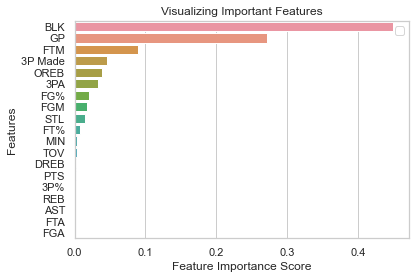

In [446]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [447]:
# make predictions for test data
y_pred_gbm = gbm.predict(X_test)

In [448]:
print(classification_report(y_test, y_pred_gbm))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1306
           1       0.79      0.78      0.79      1362

    accuracy                           0.78      2668
   macro avg       0.78      0.78      0.78      2668
weighted avg       0.78      0.78      0.78      2668



In [449]:
from sklearn import metrics
print("roc_auc:",metrics.accuracy_score(y_test, y_pred_gbm))

roc_auc: 0.7807346326836582


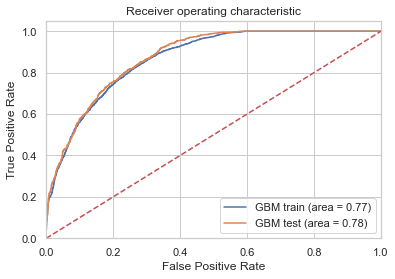

In [450]:
logit_roc_auc_test = roc_auc_score(y_test, gbm.predict(X_test))
logit_roc_auc_train = roc_auc_score(y_train, gbm.predict(X_train))
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, gbm.predict_proba(X_test)[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, gbm.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr_train, tpr_train, label='GBM train (area = %0.2f)' % logit_roc_auc_train)
plt.plot(fpr_test, tpr_test, label='GBM test (area = %0.2f)' % logit_roc_auc_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [451]:
y_test_preds = gbm.predict(df_test)

In [452]:
print(df_test.shape)

(3799, 19)


In [458]:
#printout prediction into a file
submission = pd.DataFrame({'Id':test['Id'],'TARGET_5Yrs':y_test_preds})
submission.to_csv('data/submission/submission_week3_gbm.csv',index=False)

In [456]:
print(submission)

        Id  TARGET_5Yrs
0        0            0
1        1            0
2        2            1
3        3            1
4        4            0
...    ...          ...
3794  3794            1
3795  3795            1
3796  3796            0
3797  3797            1
3798  3798            1

[3799 rows x 2 columns]
